# COVID-19 Lung CT Lesion Segmentation Challenge - 2020
3D Nifti CT image 
# 0. Check GPU for CUDA

In [ ]:
import torch
print(torch.cuda.device_count())
cuda0 = torch.device('cuda:0')

1


# 1. Setup Section

In [ ]:
#for colab users only - mounting the drive 
from google.colab import drive
drive.mount('/content/drive',force_remount = False)

#setup a base directory where everything will be installed - repo, dataset, libraries
#This .ipynb notebook needs to placed there as well.
import os
base_dir = '/content/drive/My Drive/Colab Notebooks'
os.chdir(base_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Clone the repository

In [ ]:
#comment after installed once
# !git clone https://github.com/MIC-DKFZ/nnUNet.git
# !git clone https://github.com/NVIDIA/apex

# 3. Install and Import Libraries

In [ ]:
#colab users - Do this everytime
#local machines - Once is enough
respository_dir = os.path.join(base_dir,'nnUNet')
os.chdir(respository_dir)

!pip install -e .
#(optional installation)
!pip install --upgrade git+https://github.com/nanohanno/hiddenlayer.git@bugfix/get_trace_graph#egg=hiddenlayer
!pip install Wand
os.chdir(base_dir)

Obtaining file:///content/drive/.shortcut-targets-by-id/1erd_L3trtSyFV3KHbBblXLde2zEdTfmr/nnUNet
  Using cached dicom2nifti-2.3.0.tar.gz (33 kB)
  Using cached MedPy-0.4.0.tar.gz (151 kB)
     |████████████████████████████████| 57 kB 5.2 MB/s 
     |████████████████████████████████| 48.4 MB 1.1 MB/s 
     |████████████████████████████████| 96 kB 7.5 MB/s 
     |████████████████████████████████| 2.0 MB 82.6 MB/s 
  Created wheel for batchgenerators: filename=batchgenerators-0.23-py3-none-any.whl size=84780 sha256=63fd98c2fe2ddf5d59f66324cbd83f54d49c9816ea4d53cb6f52e4c72907d3f9
  Stored in directory: /root/.cache/pip/wheels/81/3d/a2/9a602ce56458c684d2962ec89eddd6bc06b00687735e2dd11a
  Created wheel for dicom2nifti: filename=dicom2nifti-2.3.0-py3-none-any.whl size=42932 sha256=0f88e12c364a1512a280f3e4f6bb51dd52f65c2d80b4c145cc7ff2bd3ba7024d
  Stored in directory: /root/.cache/pip/wheels/bf/ff/aa/f5b52fd2e9f9355a28a6f6f6994d721a13209387528b146db5
  Created wheel for medpy: filename=MedPy-0

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
  Cloning https://github.com/nanohanno/hiddenlayer.git (to revision bugfix/get_trace_graph) to /tmp/pip-install-awvaa83_/hiddenlayer_ed86ba7dde8c4d5d9024731c84dd53d1
  Running command git clone -q https://github.com/nanohanno/hiddenlayer.git /tmp/pip-install-awvaa83_/hiddenlayer_ed86ba7dde8c4d5d9024731c84dd53d1
  Running command git checkout -b bugfix/get_trace_graph --track origin/bugfix/get_trace_graph
  Switched to a new branch 'bugfix/get_trace_graph'
  Branch 'bugfix/get_trace_graph' set up to track remote branch 'bugfix/get_trace_graph' from 'origin'.
  Created wheel for hiddenlayer: filename=hiddenlayer-0.2-py3-none-any.whl size=19748 sha256=3302e16e0e8295a95da38c5642fdeb00226a79ddda0250cf288afbe7226f2d43
  Stored in directory: /tmp/pip-ephem-wheel-ca

(Colab Users: You must restart your runtime after installing the libraries.)

In [ ]:
#libraries
import shutil
from collections import OrderedDict
import json
import numpy as np

#visualization of the dataset
import matplotlib.pyplot as plt
import nibabel as nib


#for colab users only - keep the base directory same as above
import os
base_dir = "/content/drive/My Drive/Colab Notebooks"
repository_dir = os.path.join(base_dir,'nnUNet')
os.chdir(base_dir)

if os.getcwd()==base_dir:
    print('We are in the correct directory')
else:
    print("Run set base directory step again, then check to verify.")

We are in the correct directory


# 4. Dataset Folder Structure

In [ ]:
def make_if_dont_exist(folder_path,overwrite=False):
    """
    creates a folder if it does not exists
    input: 
    folder_path : relative path of the folder which needs to be created
    over_write :(default: False) if True overwrite the existing folder 
    """
    if os.path.exists(folder_path):
        
        if not overwrite:
            print(f'{folder_path} exists.')
        else:
            print(f"{folder_path} overwritten")
            shutil.rmtree(folder_path)
            os.makedirs(folder_path)

    else:
      os.makedirs(folder_path)
      print(f"{folder_path} created!")

In [ ]:
task_name = 'Task101_COVID' #change here for different task name
nnunet_dir = "nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data"
task_folder_name = os.path.join(nnunet_dir,task_name)
train_image_dir = os.path.join(task_folder_name,'imagesTr')
train_label_dir = os.path.join(task_folder_name,'labelsTr')
test_dir = os.path.join(task_folder_name,'imagesTs')
sample_dir = os.path.join(task_folder_name,'sample_prediction')
main_dir = os.path.join(base_dir,'nnUNet/nnunet')

In [ ]:
make_if_dont_exist(task_folder_name,overwrite = False)
make_if_dont_exist(train_image_dir)
make_if_dont_exist(train_label_dir)
make_if_dont_exist(test_dir,overwrite= False)
make_if_dont_exist(os.path.join(main_dir,'nnunet_trained_models'))

nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_COVID exists.
nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_COVID/imagesTr exists.
nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_COVID/labelsTr exists.
nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_COVID/imagesTs exists.
/content/drive/My Drive/Colab Notebooks/nnUNet/nnunet/nnunet_trained_models exists.


In [ ]:
os.environ['nnUNet_raw_data_base'] = os.path.join(main_dir,'nnUNet_raw_data_base')
os.environ['nnUNet_preprocessed'] = os.path.join(main_dir,'preprocessed')
os.environ['RESULTS_FOLDER'] = os.path.join(main_dir,'nnUNet_trained_models')

___
Colab Users: Everytime you re-run or restart your kernel always run until this point.
# 6. Unzip, Rename, Train and Test Set

In [ ]:
def copy_and_rename(old_location,old_file_name,new_location,new_filename,delete_original = False):

    shutil.copy(os.path.join(old_location,old_file_name),new_location)
    os.rename(os.path.join(new_location,old_file_name),os.path.join(new_location,new_filename))
    if delete_original:
        os.remove(os.path.join(old_location,old_file_name))

In [ ]:
for file in os.listdir(task_folder_name):#task_folder_name
    if file.endswith('.nii.gz'):
        if file.find('_ct') != -1:
            new_filename = file[:file.find('_ct')]+'.nii.gz'
            print(new_filename)
            copy_and_rename(task_folder_name, file, train_image_dir, new_filename, delete_original = True)
        elif file.find('_seg') != -1:
            new_filename = file[:file.find('_seg')]+'.nii.gz'
            print(new_filename)
            copy_and_rename(task_folder_name, file, train_label_dir, new_filename, delete_original = True)

In [ ]:
train_files = os.listdir(train_image_dir)
label_files = os.listdir(train_label_dir)
print("train image files:",len(train_files))
print("train label files:",len(label_files))
print("Matches:",len(set(train_files).intersection(set(label_files))))

print("Testing files:",len(os.listdir(test_dir)))
print(test_dir)

train image files: 25
train label files: 25
Matches: 0
Testing files: 50
nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task101_COVID/imagesTs


In [ ]:
#renaming to add the modality for SCGM there is only one modality 
#images should be added with 0000
#can be skipped if modality is already mentioned
#re-write for multiple modalities

def rename_for_single_modality(directory):
    # if directory.find('imagesTs') != -1:
        for file in os.listdir(directory):
            print(f"original file name {file}")
            new_name = file[:file.find('.nii.gz')]+"_0000.nii.gz"
            # os.rename(os.path.join(directory,file),os.path.join(directory,new_name))
            print(f"------->Renamed to {new_name}")

# This is one time only, everything is in right format already.
# rename_for_single_modality(train_image_dir) 
# rename_for_single_modality(sample_dir)


## Creating dataset.json

In [ ]:
overwrite_json_file = True #make it True if you want to overwrite the dataset.json file in Task_folder
json_file_exist = False

if os.path.exists(os.path.join(task_folder_name,'dataset.json')):
    print('dataset.json already exist!')
    json_file_exist = True

if json_file_exist==False or overwrite_json_file:

    json_dict = OrderedDict()
    json_dict['name'] = task_name
    json_dict['description'] = "COVID-19 Lung CT Lesion Segmentation Challenge - 2020"
    json_dict['tensorImageSize'] = "3D"
    json_dict['reference'] = "see challenge website"
    json_dict['licence'] = "see challenge website"
    json_dict['release'] = "0.0"

    #you may mention more than one modality
    json_dict['modality'] = {
        "0": "CT"
    }

    #labels+1 should be mentioned for all the labels in the dataset
    json_dict['labels'] = {
        "0": "background",
        "1": "lesion",
    }
    
    train_ids = os.listdir(train_label_dir)
    test_ids = os.listdir(test_dir)
    json_dict['numTraining'] = len(train_ids)
    json_dict['numTest'] = len(test_ids)

    #no modality in train image and labels in dataset.json 
    json_dict['training'] = [{'image': "./imagesTr/%s" % i, "label": "./labelsTr/%s" % i} for i in train_ids]

    #removing the modality from test image name to be saved in dataset.json
    json_dict['test'] = ["./imagesTs/%s" % (i[:i.find("_0000")]+'.nii.gz') for i in test_ids]


    with open(os.path.join(task_folder_name,"dataset.json"), 'w') as f:
        json.dump(json_dict, f, indent=4, sort_keys=True)

    if os.path.exists(os.path.join(task_folder_name,'dataset.json')):
        if json_file_exist==False:
            print('dataset.json created!')
        else: 
            print('dataset.json overwritten!')

dataset.json already exist!
dataset.json overwritten!


# 7. Dataset Verification

In [ ]:
#running it from the experiment_planning folder to verify the path settings
os.chdir(main_dir)
!python experiment_planning/nnUNet_plan_and_preprocess.py -t 101 --verify_dataset_integrity -tl 1 -tf 1
os.chdir(base_dir)



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

Verifying training set
checking case volume-covid19-A-0053
checking case volume-covid19-A-0066
checking case volume-covid19-A-0054
checking case volume-covid19-A-0003
checking case volume-covid19-A-0025
checking case volume-covid19-A-0034
checking case volume-covid19-A-0077
checking case volume-covid19-A-0038
checking case volume-covid19-A-0039
checking case volume-covid19-A-0074_1
checking case volume-covid19-A-0092
checking case volume-covid19-A-0031
checking case volume-covid19-A-0011
checking case volume-covid19-A-0016
checking case volume-covid19-A-0013
checking case volume-covid19-A-0014
checking case volume-covid19-A-0072
c

# 8. Dataset Visualization

In [ ]:
import numpy as np

def display_views(file_path, shape):
    image_axis = 2
    medical_image = nib.load(file_path)
    image = medical_image.get_fdata()
    
    sagital_image = image[shape[0]//2, :, :] # Axis 0
    axial_image = image[:, :, shape[2]//2] # Axis 2
    coronal_image = image[:, shape[1]//2, :] # Axis 1
    
    plt.figure(figsize=(20, 10))
    plt.style.use('default')
    
    plt.subplot(141)
    plt.imshow(np.rot90(sagital_image), aspect=5)
    plt.title('Sagital Plane')
    plt.axis('off')

    plt.subplot(142)
    plt.imshow(np.rot90(axial_image))
    plt.title('Axial Plane')
    plt.axis('off')

    plt.subplot(143)
    plt.imshow(np.rot90(coronal_image), aspect=5)
    plt.title('Coronal Plane')
    plt.axis('off')

    plt.show()

## Train Data

volume-covid19-A-0031_0000.nii.gz (512, 512, 73)


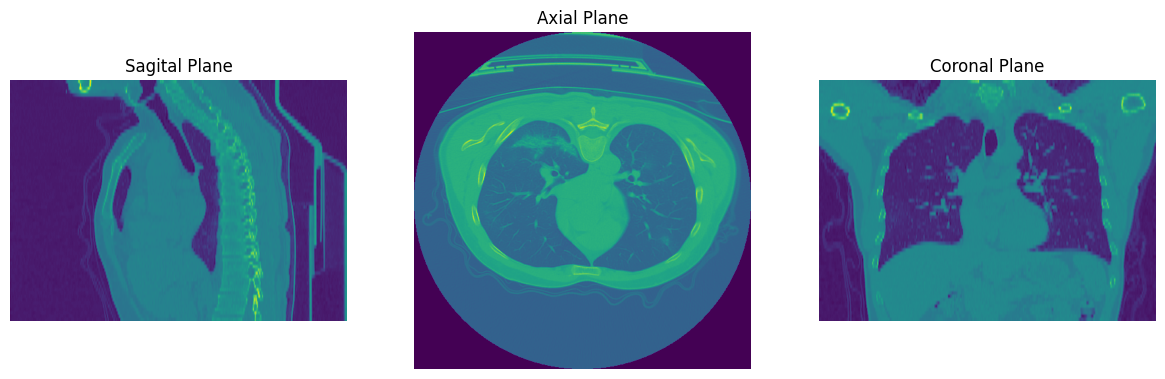

In [ ]:
#visualizing one of the training images and labels
# (re-run to see random pick-ups)

train_img_sel = os.listdir(train_image_dir)[np.random.randint(0,25)]
train_img_name = os.path.join(train_image_dir, train_img_sel)
train_img_shape = nib.load(train_img_name).get_fdata().shape
print(train_img_sel, train_img_shape)
display_views(train_img_name, train_img_shape)

volume-covid19-A-0031.nii.gz (512, 512, 73)


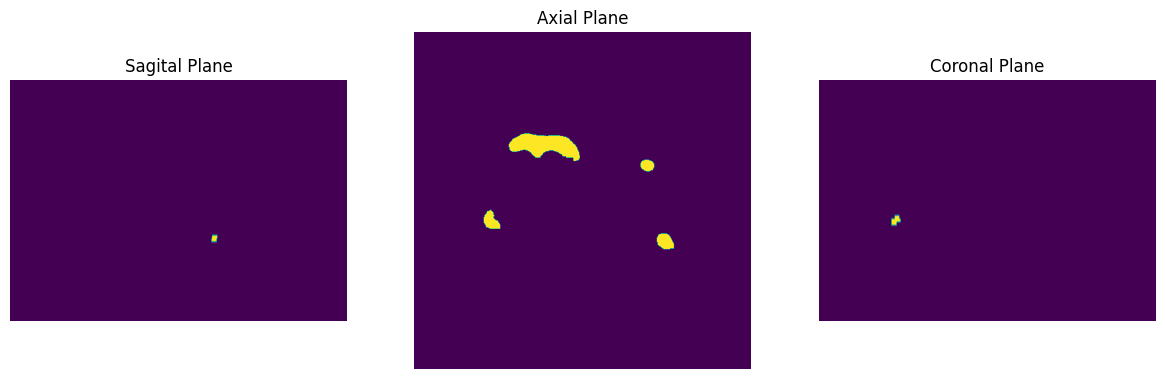

In [ ]:
train_label_sel = train_img_sel.split('_0000')[0]+'.nii.gz'
train_label_name = os.path.join(train_label_dir, train_label_sel)
train_img_shape = nib.load(train_label_name).get_fdata().shape
print(train_label_sel, train_img_shape)
display_views(train_label_name, train_img_shape)

## Test Data

volume-covid19-A-0229_0000.nii.gz (512, 512, 71)


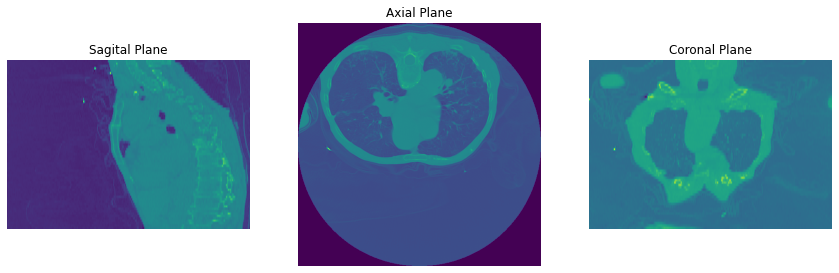

In [ ]:
#visualizing one of the test images
# (re-run to see random pick-ups)

test_img_sel = os.listdir(test_dir)[np.random.randint(0,50)]
test_img_name = os.path.join(test_dir, test_img_sel)
test_img_shape = nib.load(test_img_name).get_fdata().shape
print(test_img_sel, test_img_shape)
display_views(test_img_name, test_img_shape)

# 9. Training Code

In [ ]:
#colab users - mandatory
#local machine - once is sufficient
os.chdir('apex')
!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./
os.chdir(base_dir)

/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:232: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.headers does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/include/python3.7/UNKNOWN
sysconfig: /usr/include/python3.7m/UNKNOWN
Value for scheme.scripts does not match. Please report this to <https://github.com/pypa/p

### Training options: 2D, 3D Full resolution, Cascaded 3D
we are using 3D Full resolution with out post-processing.

nnU-Net stores a checkpoint every 50 epochs. If you need to continue a previous training, just add a -c to the training command.

In [ ]:
os.chdir(main_dir)
!nnUNet_train 3d_fullres nnUNetTrainerV2 101 0 -c
os.chdir(base_dir)



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 3d_fullres
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2.nnUNetTrainerV2'>
For that I will be using the following configuration:
num_classes:  1
modalities:  {0: 'CT'}
use_mask_for_norm OrderedDict([(0, False)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'CT')])
stages...

stage:  0
{'batch_size': 2, 'num_pool_per_axis': [4, 5, 5], 'patch_size': array([ 96, 160, 160]), 'median_patient_size_in_voxels': array([157, 248, 248]), 'current_spa

# 10. Training Result

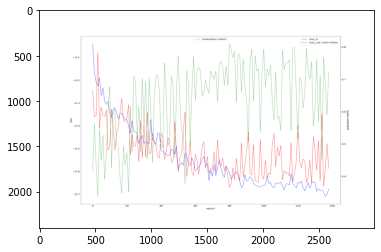

In [ ]:
import matplotlib.image as img
trained_model_dir = os.path.join(base_dir, 'nnUNet/nnunet/nnUNet_trained_models/nnUNet/3d_fullres/Task101_COVID/nnUNetTrainerV2__nnUNetPlansv2.1/fold_0')
progress_img = img.imread(os.path.join(trained_model_dir, 'progress0.png'))
plt.imshow(progress_img, aspect='auto')


### Best Model at epoch 57
2021-12-18 16:18:37.090450: <br>
epoch:  57 <br>
2021-12-18 16:28:24.811323: train loss : -0.5747 <br>
2021-12-18 16:28:52.741492: validation loss: -0.4634 <br>
2021-12-18 16:28:52.745436: Average global foreground <br>Dice: [0.4958] <br>
2021-12-18 16:28:52.747907: (interpret this as an estimate for the Dice of the different classes. This is not exact.) <br>
2021-12-18 16:28:53.904709: lr: 0.009476 <br>
2021-12-18 16:28:53.907268: This epoch took 616.814318 s

### Network Architecture

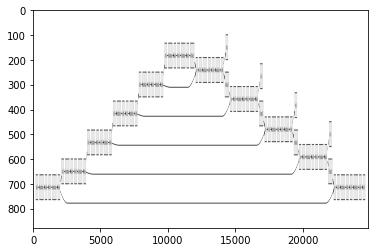

In [ ]:
net_arch_img = img.imread(os.path.join(trained_model_dir, 'network_architecture-1.png'))
plt.imshow(net_arch_img, aspect='auto')

# 11. Inference Code

In [ ]:
result_dir = os.path.join(main_dir,'nnUNet_Prediction_Results',task_name)
make_if_dont_exist(result_dir)
team_name = 'Pepe Naruto' #make sure to change for your own team nam
#location where you want save your results, will be created if dont exist
os.chdir(main_dir)
!nnUNet_predict -i nnUNet_raw_data_base/nnUNet_raw_data/Task101_COVID/imagesTs -o nnUNet_Prediction_Results/Task101_COVID -t 101 -tr nnUNetTrainerV2 -m 3d_fullres --num_threads_preprocessing 1
os.chdir(base_dir)

/content/drive/My Drive/Colab Notebooks/nnUNet/nnunet/nnUNet_Prediction_Results/Task101_COVID exists.


Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

using model stored in  /content/drive/My Drive/Colab Notebooks/nnUNet/nnunet/nnUNet_trained_models/nnUNet/3d_fullres/Task101_COVID/nnUNetTrainerV2__nnUNetPlansv2.1
This model expects 1 input modalities for each image
Found 50 unique case ids, here are some examples: ['volume-covid19-A-0064' 'volume-covid19-A-0345' 'volume-covid19-A-0457'
 'volume-covid19-A-0376' 'volume-covid19-A-0082' 'volume-covid19-A-0490'
 'volume-covid19-A-0543' 'volume-covid19-A-0091' 'volume-covid19-A-0509'
 'volume-covid19-A-0026']
If they don't look right

# 12. Prediction Visualization

volume-covid19-A-0318_0_0000.nii.gz (512, 512, 61)


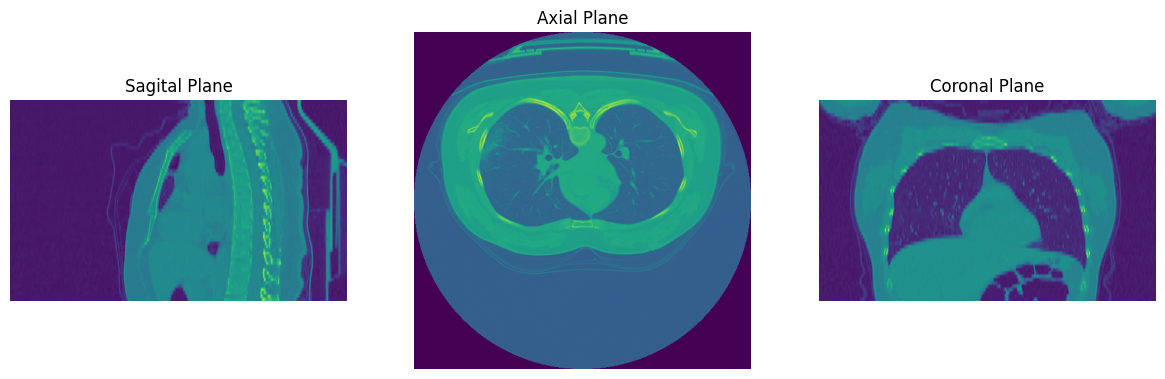

In [ ]:
#visualizing the predicted results
# (re-run to see random pick-ups)

test_img_sel = os.listdir(test_dir)[np.random.randint(0,50)]
test_img_name = os.path.join(test_dir, test_img_sel)
test_img_shape = nib.load(test_img_name).get_fdata().shape
print(test_img_sel, test_img_shape)
display_views(test_img_name, test_img_shape)

volume-covid19-A-0318_0.nii.gz (512, 512, 61)


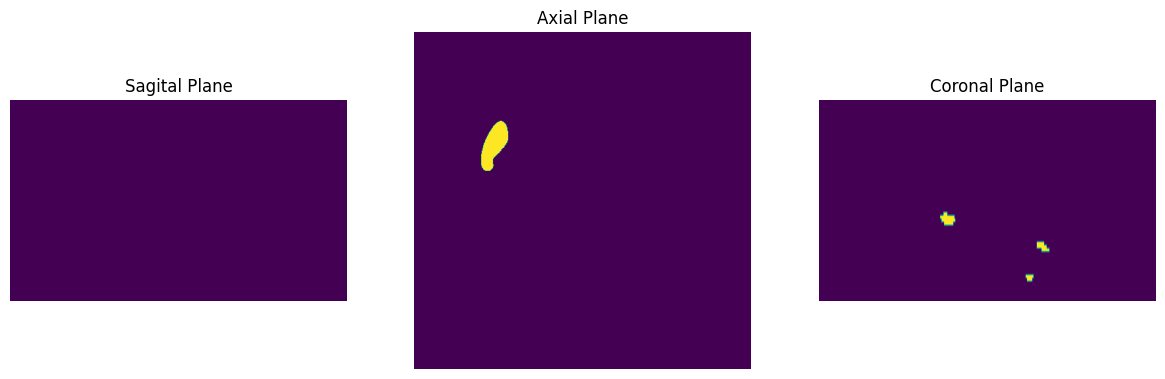

In [ ]:
result_dir = os.path.join(main_dir,'nnUNet_Prediction_Results',task_name)
predicted_img_sel = test_img_sel.split('_0000')[0]+'.nii.gz'
predicted_img_name = os.path.join(result_dir, predicted_img_sel)
predicted_img_shape = nib.load(predicted_img_name).get_fdata().shape
print(predicted_img_sel, predicted_img_shape)
display_views(predicted_img_name, predicted_img_shape)

Comparison with the mactching sample submission file from the host of Grand Challenge

318_0.nii.gz (512, 512, 61)


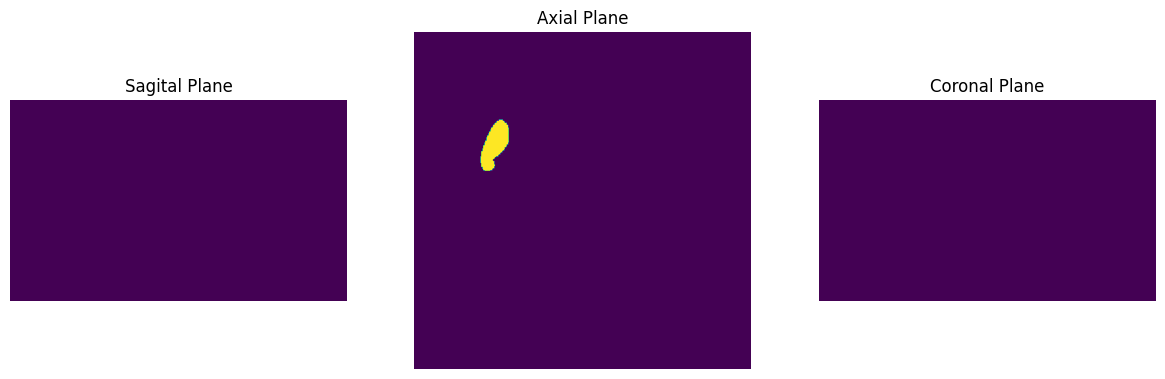

In [ ]:
sample_img_sel = test_img_sel.split('-')[-1]
sample_img_sel = sample_img_sel[:sample_img_sel.find('_0000')][1:] + '.nii.gz'
sample_img_name = os.path.join(sample_dir, sample_img_sel)
sample_img_shape = nib.load(sample_img_name).get_fdata().shape
print(sample_img_sel, sample_img_shape)
display_views(sample_img_name, sample_img_shape)

# 13. Futher Steps
1. Consider Using [Ensemble Learning](https://en.wikipedia.org/wiki/Ensemble_learning).

nnU-Net provides ensemble learning.
2. Additional Data: Medical Segmentation Decathlon

FOLDER_TO_TASK_AS_DOWNLOADED_FROM_MSD needs to point to the downloaded task folder (such as Task05_Prostate, note the 2-digit task id!). 

The converted Task will be saved under the same name in nnUNet_raw_data_base/nnUNet_raw_data (but with a 3 digit identifier). 

You can overwrite the task id of the converted task by using the '-output_task_id' option.




In [ ]:
# !nnUNet_convert_decathlon_task -i FOLDER_TO_TASK_AS_DOWNLOADED_FROM_MSD -p NUM_PROCESSES

# 14. Reference
[Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020).](https://doi.org/10.1038/s41592-020-01008-z)

[MIC-DKFZ, nnU-Net](https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/expected_epoch_times.md)


[MICCAI Educational Initiative, nnU-Net : The no-new-UNet for automatic segmentation](https://medium.com/miccai-educational-initiative/nnu-net-the-no-new-unet-for-automatic-segmentation-8d655f3f6d2a)